In [61]:
# Student data generator for digital transformation dataset
import pandas as pd
import numpy as np

# Write your student number here
STUDENT_number = 715056

# Load data
df = pd.read_csv('digital_transformation.csv')
np.random.seed(STUDENT_number)
noise_vars = ['revenue', 'productivity_score', 'employee_satisfaction', 'customer_satisfaction', 'ceo_experience']
for var in noise_vars:
    df[var] += np.random.normal(0, df[var].std() * 0.05)

# Save unique dataset
df.to_csv('digital_transformation_unique.csv', index=False)

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import gaussian_kde, f
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from causalml.inference.tree import CausalTreeRegressor
import warnings
warnings.filterwarnings('ignore')

In [63]:
# List all variables (columns) in the dataset
print("Variables in dataset:")
print(df.columns.tolist())

# Display descriptive statistics for numeric variables
print("\nDescriptive Statistics (Numeric):")
print(df.describe())

# Display descriptive statistics for non-numeric variables (if any)
print("\nDescriptive Statistics (Non-Numeric):")
print(df.describe(include=['object']))

Variables in dataset:
['firm_id', 'year', 'industry_type', 'firm_strategy', 'firm_size', 'firm_age', 'ceo_experience', 'ceo_tenure', 'prior_tech_adoption', 'tech_budget_pct', 'digital_transformation_program', 'market_conditions', 'revenue', 'revenue_growth', 'operating_costs', 'rd_spending', 'productivity_score', 'employee_satisfaction', 'customer_satisfaction', 'profit_margin', 'rd_intensity', 'large_firm', 'post_2020']

Descriptive Statistics (Numeric):
           firm_id        year      firm_size    firm_age  ceo_experience  \
count  3000.000000  3000.00000    3000.000000  3000.00000     3000.000000   
mean    250.500000  2020.50000   11203.480333    23.31000       10.222409   
std     144.361341     1.70811   30609.496929    10.39724        7.752553   
min       1.000000  2018.00000      23.000000     4.00000        2.106009   
25%     125.750000  2019.00000    1364.000000    14.00000        4.381009   
50%     250.500000  2020.50000    3698.500000    23.00000        7.806009   
7

In [74]:
def load_and_validate_data():
   """Load and validate digital transformation dataset with improved processing."""
   try:
       df = pd.read_csv('digital_transformation_unique.csv')
       print("✅ Dataset loaded successfully!")
       print(f"📊 Shape: {df.shape}")
       
       # Basic validation checks
       print(f"📅 Year range: {df['year'].min()} - {df['year'].max()}")
       print(f"🏢 Number of firms: {df['firm_id'].nunique()}")
       print(f"📈 Treatment prevalence: {df['digital_transformation_program'].mean():.1%}")
       
       # Check for missing values
       missing_summary = df.isnull().sum()
       if missing_summary.sum() > 0:
           print("⚠️ Missing values detected:")
           print(missing_summary[missing_summary > 0])
       else:
           print("✅ No missing values found")
       
       # Validate panel structure
       panel_check = df.groupby('firm_id')['year'].count()
       print(f"📊 Panel balance check:")
       print(panel_check.value_counts().sort_index())
       
       # Key outcome variables summary
       print(f"\n📈 Outcome Variables Summary:")
       print(f"Productivity Score - Mean: {df['productivity_score'].mean():.2f}, Std: {df['productivity_score'].std():.2f}")
       print(f"Employee Satisfaction - Mean: {df['employee_satisfaction'].mean():.2f}, Std: {df['employee_satisfaction'].std():.2f}")
       
       return df
       
   except FileNotFoundError:
       print("❌ Error: 'digital_transformation_unique.csv' not found!")
       return None
   except Exception as e:
       print(f"❌ Error loading data: {str(e)}")
       return None

# Call the function to load and validate data
df = load_and_validate_data()

✅ Dataset loaded successfully!
📊 Shape: (3000, 23)
📅 Year range: 2018 - 2023
🏢 Number of firms: 500
📈 Treatment prevalence: 55.8%
✅ No missing values found
📊 Panel balance check:
year
6    500
Name: count, dtype: int64

📈 Outcome Variables Summary:
Productivity Score - Mean: 54.93, Std: 17.17
Employee Satisfaction - Mean: 3.69, Std: 0.78


In [82]:
def preprocess_data(df):
    """Create essential variables for causal analysis"""
    # Feature engineering
    df['log_firm_size'] = np.log(df['firm_size'] + 1)
    df['post_treatment'] = (df['year'] > 2020).astype(int)
    
    # Industry simplification
    top_industries = df['industry_type'].value_counts().nlargest(3).index
    df['industry_group'] = df['industry_type'].where(
        df['industry_type'].isin(top_industries), 'Other'
    )
    return df

def assess_covariate_balance(df):
    """Check pre-treatment comparability of groups"""
    from tableone import TableOne
    
    covariates = ['log_firm_size', 'firm_age', 'prior_tech_adoption', 
                 'tech_budget_pct', 'ceo_experience', 'industry_group']
    
    table = TableOne(df, covariates, groupby='digital_transformation_program',
                    pval=True, smd=True, htest_name=True)
    return table

df = preprocess_data(df)

balance_table = assess_covariate_balance(df[df['year'] == 2018])  # Pre-treatment year
print(balance_table)

                                         Grouped by digital_transformation_program                                                                        
                                                                           Missing      Overall            0           1 SMD (0,1) P-Value            Test
n                                                                                           500          417          83                                  
log_firm_size, mean (SD)                                                         0    8.1 (1.5)    8.0 (1.5)   8.8 (1.4)     0.610  <0.001  Welch’s T-test
firm_age, mean (SD)                                                              0  20.8 (10.3)  20.9 (10.4)  20.3 (9.6)    -0.061   0.602  Welch’s T-test
prior_tech_adoption, n (%) 0                                                         311 (62.2)   251 (60.2)   60 (72.3)     0.258   0.051     Chi-squared
                           1                                          

                     Weighted SMD
log_firm_size           -0.042652
prior_tech_adoption     -0.002548
firm_age                 0.001243
tech_budget_pct          0.022792
ceo_experience          -0.010435


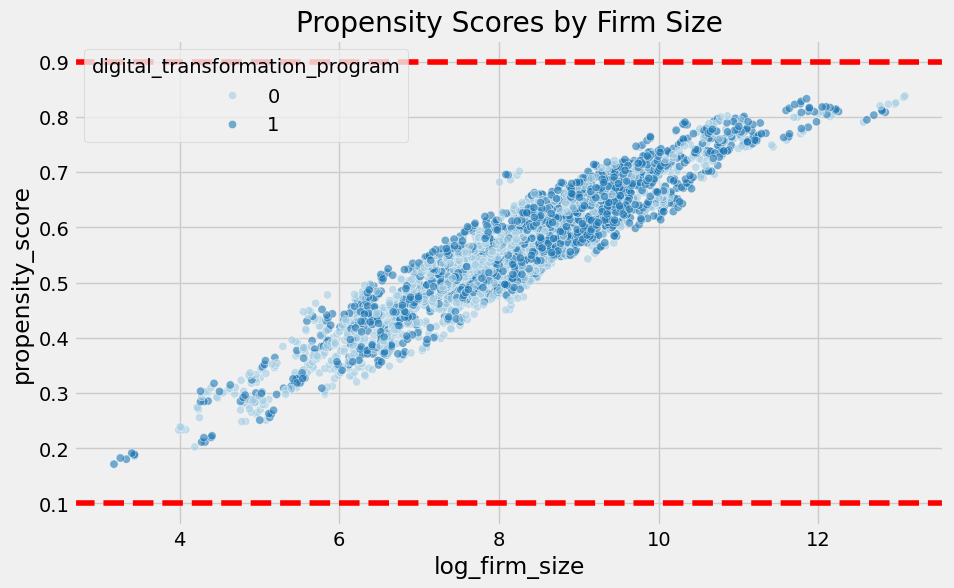

In [84]:
def estimate_propensity_scores(df):
    """Calculate propensity scores using logistic regression"""
    from sklearn.linear_model import LogisticRegression
    
    # Select confounders based on imbalance analysis
    confounders = ['log_firm_size', 'prior_tech_adoption', 
                   'firm_age', 'tech_budget_pct', 'ceo_experience']
    
    X = df[confounders]
    y = df['digital_transformation_program']
    
    # Fit propensity model
    ps_model = LogisticRegression(max_iter=1000, random_state=42)
    ps_model.fit(X, y)
    df['propensity_score'] = ps_model.predict_proba(X)[:, 1]
    
    return df

def assess_weighted_balance(df):
    """Check balance after IPTW adjustment using custom weighting"""
    # Define confounders list, same as in propensity score estimation
    confounders = ['log_firm_size', 'prior_tech_adoption', 
                   'firm_age', 'tech_budget_pct', 'ceo_experience']
    
    # Calculate weights
    df['iptw'] = np.where(df['digital_transformation_program'] == 1,
                          1 / df['propensity_score'],
                          1 / (1 - df['propensity_score']))
    
    # Calculate standardized mean differences after weighting
    weighted_balance = {}
    for var in confounders:
        treated = df['digital_transformation_program'] == 1
        control = df['digital_transformation_program'] == 0

        w_mean_treated = np.average(df.loc[treated, var],
                                    weights=df.loc[treated, 'iptw'])
        w_mean_control = np.average(df.loc[control, var],
                                    weights=df.loc[control, 'iptw'])
        
        pooled_std = np.std(df[var])
        weighted_balance[var] = {
            'Weighted SMD': (w_mean_treated - w_mean_control) / pooled_std
        }
    
    return pd.DataFrame(weighted_balance).T

df = estimate_propensity_scores(df)

weighted_balance = assess_weighted_balance(df)
print(weighted_balance)

plt.figure(figsize=(10,6))
sns.scatterplot(x='log_firm_size', y='propensity_score', 
                hue='digital_transformation_program', 
                data=df, alpha=0.6)
plt.title('Propensity Scores by Firm Size')
plt.axhline(y=0.1, color='r', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.show()

🔍 ENHANCED DATA EXPLORATION

📅 TREATMENT TIMING ANALYSIS:


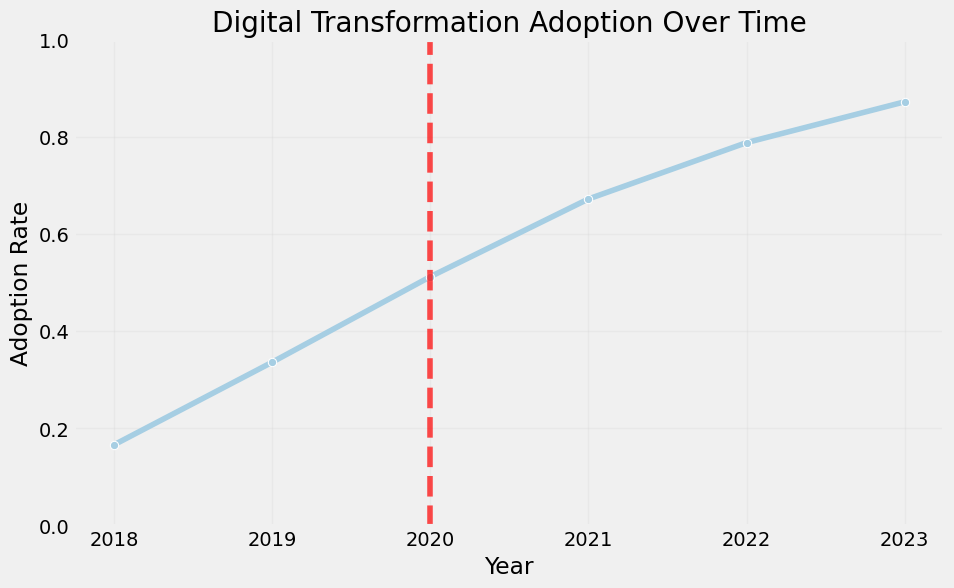

      Treatment_Rate  Total_Firms
year                             
2018           0.166          500
2019           0.336          500
2020           0.512          500
2021           0.672          500
2022           0.788          500
2023           0.872          500

⚖️ ENHANCED TREATMENT IMBALANCE DIAGNOSTICS:

📈 NUMERIC VARIABLES:
             Covariate  Treated_Mean  Control_Mean       SMD  |SMD|>0.25
0        log_firm_size      8.485473      7.792305  0.457786        True
3         rd_intensity      0.055900      0.045298  0.436317        True
1  prior_tech_adoption      0.362224      0.397890 -0.073544       False
2      tech_budget_pct      0.086561      0.084194  0.063921       False
4       ceo_experience     10.436075      9.953033  0.062308       False
5    market_conditions     -0.026233     -0.030274  0.034287       False

📊 CATEGORICAL VARIABLES:
        Covariate  Max_Category_Diff  |Diff|>0.1
0   firm_strategy           0.042899       False
1  industry_group        

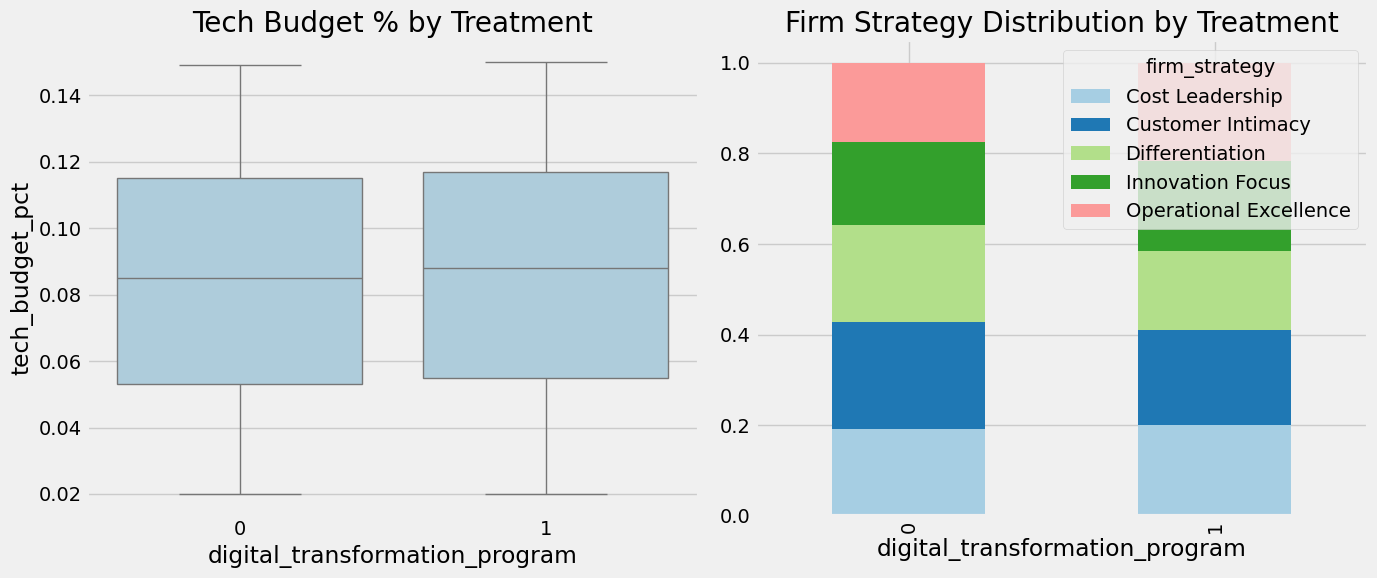


🔗 OUTCOME CORRELATION NETWORK:


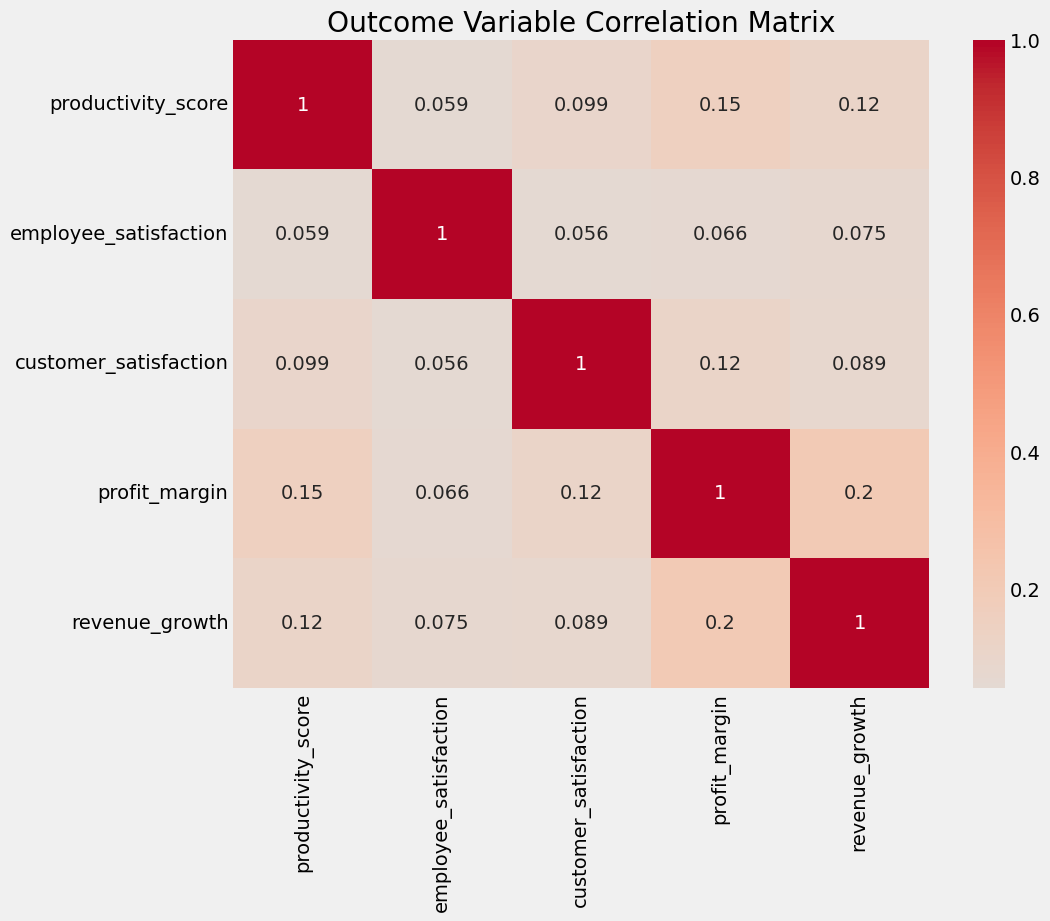


🔍 MULTICOLLINEARITY DIAGNOSTICS:

Variance Inflation Factors:
                Feature        VIF
0         log_firm_size  14.698840
1              firm_age   5.770360
5       tech_budget_pct   5.758441
7          rd_intensity   5.187502
9        industry_group   4.534927
10            post_2020   3.113260
8         firm_strategy   2.808848
2        ceo_experience   2.698574
3            ceo_tenure   2.471071
4   prior_tech_adoption   1.585479
6     market_conditions   1.085622

🔴 Critical multicollinearity (VIF > 10):
         Feature       VIF
0  log_firm_size  14.69884


In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor


def enhanced_data_exploration(df):
    """Enhanced exploration with proper handling of categorical variables."""
    print("=" * 60)
    print("🔍 ENHANCED DATA EXPLORATION")
    print("=" * 60)
    
    # 1. Treatment timing analysis
    print("\n📅 TREATMENT TIMING ANALYSIS:")
    treatment_by_year = (
        df.groupby('year')['digital_transformation_program']
          .agg(['mean', 'count'])
          .rename(columns={'mean': 'Treatment_Rate', 'count': 'Total_Firms'})
    )
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=treatment_by_year, x=treatment_by_year.index, y='Treatment_Rate', marker='o')
    plt.axvline(2020, color='r', linestyle='--', alpha=0.7)
    plt.title('Digital Transformation Adoption Over Time')
    plt.ylabel('Adoption Rate')
    plt.xlabel('Year')
    plt.ylim(0, 1)
    plt.grid(alpha=0.2)
    plt.show()
    print(treatment_by_year)
    
    # 2. Enhanced imbalance diagnostics
    print("\n⚖️ ENHANCED TREATMENT IMBALANCE DIAGNOSTICS:")
    
    # Separate numeric and categorical variables
    numeric_vars = [
        'log_firm_size',
        'prior_tech_adoption',
        'tech_budget_pct',
        'rd_intensity',
        'ceo_experience',
        'market_conditions'
    ]
    categorical_vars = ['firm_strategy', 'industry_group']
    
    # Numeric diagnostics
    print("\n📈 NUMERIC VARIABLES:")
    num_metrics = []
    for cov in numeric_vars:
        treated = df[df['digital_transformation_program'] == 1][cov]
        control = df[df['digital_transformation_program'] == 0][cov]
        sd = df[cov].std()
        smd = (treated.mean() - control.mean()) / sd if sd != 0 else np.nan
        num_metrics.append({
            'Covariate': cov,
            'Treated_Mean': treated.mean(),
            'Control_Mean': control.mean(),
            'SMD': smd,
            '|SMD|>0.25': abs(smd) > 0.25
        })
    num_df = pd.DataFrame(num_metrics).sort_values('SMD', key=lambda x: x.abs(), ascending=False)
    print(num_df)
    
    # Categorical diagnostics
    print("\n📊 CATEGORICAL VARIABLES:")
    cat_metrics = []
    for cov in categorical_vars:
        prop = (
            df.groupby(['digital_transformation_program', cov])
              .size()
              .unstack(fill_value=0)
              .pipe(lambda tbl: tbl.div(tbl.sum(axis=1), axis=0))
        )
        if set([0, 1]).issubset(prop.index):
            max_diff = (prop.loc[1] - prop.loc[0]).abs().max()
        else:
            max_diff = np.nan
        cat_metrics.append({
            'Covariate': cov,
            'Max_Category_Diff': max_diff,
            '|Diff|>0.1': max_diff > 0.1
        })
    cat_df = pd.DataFrame(cat_metrics)
    print(cat_df)
    
    # Visual diagnostics
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.boxplot(x='digital_transformation_program', y='tech_budget_pct', data=df, ax=axes[0])
    axes[0].set_title('Tech Budget % by Treatment')
    strat_props = (
        df.groupby('digital_transformation_program')['firm_strategy']
          .value_counts(normalize=True)
          .unstack(fill_value=0)
    )
    strat_props.plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title('Firm Strategy Distribution by Treatment')
    plt.tight_layout()
    plt.show()
    
    # 3. Outcome correlation network
    print("\n🔗 OUTCOME CORRELATION NETWORK:")
    outcome_vars = [
        'productivity_score',
        'employee_satisfaction',
        'customer_satisfaction',
        'profit_margin',
        'revenue_growth'
    ]
    corr_matrix = df[outcome_vars].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Outcome Variable Correlation Matrix')
    plt.show()
    
    return treatment_by_year, (num_df, cat_df)


def check_multicollinearity(df, covariates):
    """Robust multicollinearity diagnostics with proper type handling"""
    print("\n🔍 MULTICOLLINEARITY DIAGNOSTICS:")
    X = df[covariates].copy()
    
    # Convert non-numeric to numeric codes
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = X[col].astype('category').cat.codes
        elif X[col].dtype == 'bool':
            X[col] = X[col].astype(int)
    
    # Coerce to numeric and fill
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # VIF calculation
    vif_data = pd.DataFrame({
        'Feature': X.columns,
        'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    }).sort_values('VIF', ascending=False)
    
    # Reporting
    print("\nVariance Inflation Factors:")
    print(vif_data)
    high = vif_data[vif_data['VIF'] > 10]
    moderate = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]
    if not high.empty:
        print("\n🔴 Critical multicollinearity (VIF > 10):")
        print(high)
    elif not moderate.empty:
        print("\n🟠 Moderate multicollinearity (5 < VIF ≤ 10):")
        print(moderate)
    else:
        print("\n🟢 No significant multicollinearity detected")
    
    return vif_data


# Key covariates for the model
key_covariates = [
    'log_firm_size',
    'firm_age',
    'ceo_experience',
    'ceo_tenure',
    'prior_tech_adoption',
    'tech_budget_pct',
    'market_conditions',
    'rd_intensity',
    'firm_strategy',
    'industry_group',
    'post_2020'
]

# Execute analysis
treatment_timing, imbalance_df = enhanced_data_exploration(df)
vif_results = check_multicollinearity(df, key_covariates)

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from causalml.inference.tree import CausalTreeRegressor
from sklearn.model_selection import train_test_split

# ======================
# DATA PREPARATION
# ======================

def load_and_validate_data():
    """Load and validate digital transformation dataset"""
    df = pd.read_csv('digital_transformation_unique.csv')
    print("✅ Dataset loaded successfully")
    return df

def preprocess_data(df):
    """Feature engineering with proper time-varying covariates"""
    # Create log firm size
    df['log_firm_size'] = np.log(df['firm_size'] + 1)
    
    # Create firm size bins
    df['firm_size_bin'] = pd.cut(df['log_firm_size'], 
                                bins=[0, 7, 9, 11, 15],
                                labels=['Micro', 'Small', 'Medium', 'Large'])
    
    # Time-varying covariates with lags
    df = df.sort_values(['firm_id', 'year'])
    df['rd_intensity_lag1'] = df.groupby('firm_id')['rd_intensity'].shift(1)
    df['tech_budget_change'] = df.groupby('firm_id')['tech_budget_pct'].diff()
    
    # CEO experience growth
    df['ceo_exp_growth'] = df.groupby('firm_id')['ceo_experience'].diff()
    
    return df.dropna(subset=['rd_intensity_lag1', 'tech_budget_change', 'ceo_exp_growth'])

# ======================
# AVERAGE TREATMENT EFFECTS
# ======================

def run_basic_did(df, outcome):
    """Basic DiD with fixed effects"""
    df_panel = df.set_index(['firm_id', 'year'])
    model = PanelOLS.from_formula(
        f"{outcome} ~ digital_transformation_program + EntityEffects + TimeEffects",
        data=df_panel
    )
    result = model.fit(cov_type='clustered', cluster_entity=True)
    
    return {
        'ate': result.params['digital_transformation_program'],
        'se': result.std_errors['digital_transformation_program'],
        'pval': result.pvalues['digital_transformation_program'],
        'model': result
    }

def run_enhanced_did(df, outcome):
    """Enhanced DiD with time-varying covariates (industry_year_prod removed)"""
    df_panel = df.set_index(['firm_id', 'year'])
    
    # Corrected specification: include covariates as exog variables
    exog_vars = sm.add_constant(df_panel[['digital_transformation_program', 
                                         'rd_intensity_lag1', 
                                         'tech_budget_change', 
                                         'ceo_exp_growth']])
    
    model = PanelOLS(
        dependent=df_panel[outcome],
        exog=exog_vars,
        entity_effects=True,
        time_effects=True
    )
    
    result = model.fit(cov_type='clustered', cluster_entity=True)
    
    return {
        'ate': result.params['digital_transformation_program'],
        'se': result.std_errors['digital_transformation_program'],
        'pval': result.pvalues['digital_transformation_program'],
        'model': result
    }

def validate_parallel_trends(df, outcome):
    """Robust parallel trends test with multiple pre-treatment years"""
    pre_df = df[df['year'] < 2020].copy()
    
    # Create multiple lead indicators (2017-2019)
    trends_data = []
    for year in [2017, 2018, 2019]:
        pre_df[f'lead_{year}'] = (pre_df['year'] == year).astype(int) * pre_df['digital_transformation_program']
    
    # Build formula with all lead indicators
    lead_terms = " + ".join([f'lead_{y}' for y in [2017, 2018, 2019]])
    formula = (
        f"{outcome} ~ {lead_terms} + C(firm_id) + C(year) + "
        "firm_size_bin + prior_tech_adoption"
    )
    
    model = smf.ols(formula, data=pre_df).fit()
    
    # Collect results for each year
    for year in [2017, 2018, 2019]:
        trends_data.append({
            'year': year,
            'coef': model.params.get(f'lead_{year}'),
            'pval': model.pvalues.get(f'lead_{year}')
        })
    
    return pd.DataFrame(trends_data)

def plot_treatment_effects(basic_result, enhanced_result, title):
    """Visualize ATE estimates with confidence intervals"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    estimates = {
        'Basic': (basic_result['ate'], basic_result['se']),
        'Enhanced': (enhanced_result['ate'], enhanced_result['se'])
    }
    
    for i, (label, (ate, se)) in enumerate(estimates.items()):
        ci = 1.96 * se
        ax.errorbar(i, ate, yerr=ci, fmt='o', capsize=5, label=label)
    
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.7)
    ax.set_xticks(range(len(estimates)))
    ax.set_xticklabels(list(estimates.keys()))
    ax.set_title(f'Treatment Effects: {title}', fontsize=14)
    ax.set_ylabel('Average Treatment Effect', fontsize=12)
    ax.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    return fig

# ======================
# HETEROGENEOUS TREATMENT EFFECTS
# ======================

def run_causal_tree_analysis(df, outcome):
    """Causal tree for heterogeneous treatment effects"""
    # Prepare features
    features = [
        'log_firm_size', 'firm_age', 'ceo_experience', 
        'prior_tech_adoption', 'tech_budget_pct', 'rd_intensity',
        'firm_size_bin'
    ]
    
    X = df[features].copy()
    X = pd.get_dummies(X, drop_first=True)
    treatment = df['digital_transformation_program'].values
    y = df[outcome].values
    
    # Train causal tree
    ct = CausalTreeRegressor(max_depth=3, min_samples_leaf=50)
    ct.fit(X, treatment, y)
    
    # Predict heterogeneous effects
    df['hte_prediction'] = ct.predict(X)
    
    return ct, df

def analyze_moderation_effects(df, outcome, moderator):
    """Subgroup analysis for moderation effects"""
    results = {}
    unique_groups = df[moderator].unique()
    
    for group in unique_groups:
        subgroup = df[df[moderator] == group].copy()
        if len(subgroup) < 50:  # Skip small groups
            continue
            
        # Run enhanced DiD on subgroup
        subgroup_panel = subgroup.set_index(['firm_id', 'year'])
        
        # Corrected specification: include covariates as exog variables
        exog_vars = sm.add_constant(subgroup_panel[['digital_transformation_program', 
                                                  'rd_intensity_lag1', 
                                                  'tech_budget_change']])
        
        model = PanelOLS(
            dependent=subgroup_panel[outcome],
            exog=exog_vars,
            entity_effects=True,
            time_effects=True
        )
        
        result = model.fit(cov_type='clustered', cluster_entity=True)
        
        # Store results
        results[group] = {
            'ate': result.params['digital_transformation_program'],
            'se': result.std_errors['digital_transformation_program'],
            'pval': result.pvalues['digital_transformation_program'],
            'n': len(subgroup)
        }
    
    return pd.DataFrame(results).T

def visualize_heterogeneous_effects(df, outcome, moderator=None):
    """Visualize HTE distribution or subgroup effects"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    if moderator:
        # Moderation plot
        sns.pointplot(
            data=df, x=moderator, y='hte_prediction', 
            errorbar=('ci', 95), capsize=0.1, ax=ax
        )
        ax.set_title(f'Treatment Effects by {moderator}', fontsize=14)
    else:
        # HTE distribution
        sns.histplot(
            df['hte_prediction'], kde=True, 
            bins=30, color='skyblue', ax=ax
        )
        ax.axvline(df['hte_prediction'].mean(), color='r', linestyle='--')
        ax.set_title('Distribution of Treatment Effects', fontsize=14)
    
    ax.set_ylabel('Treatment Effect', fontsize=12)
    ax.set_xlabel(moderator if moderator else 'Treatment Effect', fontsize=12)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    return fig

# ======================
# MAIN ANALYSIS PIPELINE
# ======================

def main_analysis():
    """Full causal analysis workflow with ATE and HTE"""
    # 1. Load and prepare data
    print("Loading data...")
    df = load_and_validate_data()
    print("Preprocessing data...")
    df = preprocess_data(df)
    
    # 2. Run analysis for each outcome
    results = {}
    outcomes = ['productivity_score', 'employee_satisfaction']
    
    for outcome in outcomes:
        print(f"\n{'='*40}\nANALYZING: {outcome.replace('_', ' ').title()}\n{'='*40}")
        
        # 2a. ATE estimation
        print("Estimating average treatment effects...")
        basic_did = run_basic_did(df, outcome)
        enhanced_did = run_enhanced_did(df, outcome)
        trends = validate_parallel_trends(df, outcome)
        
        # 2b. HTE estimation
        print("Estimating heterogeneous treatment effects...")
        causal_tree, df_hte = run_causal_tree_analysis(df, outcome)
        
        # Store results
        results[outcome] = {
            'basic_did': basic_did,
            'enhanced_did': enhanced_did,
            'trends': trends,
            'causal_tree': causal_tree,
            'hte_data': df_hte
        }
        
        # 3. Visualizations
        print("Generating visualizations...")
        # ATE comparison
        fig_ate = plot_treatment_effects(basic_did, enhanced_did, outcome.replace('_', ' ').title())
        fig_ate.savefig(f'{outcome}_ate_comparison.png')
        plt.close(fig_ate)
        
        # HTE distribution
        fig_hte_dist = visualize_heterogeneous_effects(df_hte, outcome)
        fig_hte_dist.savefig(f'{outcome}_hte_distribution.png')
        plt.close(fig_hte_dist)
        
        # Subgroup analysis
        for moderator in ['firm_size_bin', 'prior_tech_adoption']:
            mod_results = analyze_moderation_effects(df, outcome, moderator)
            print(f"\nModeration by {moderator}:")
            print(mod_results)
            
            fig_hte_mod = visualize_heterogeneous_effects(df_hte, outcome, moderator)
            fig_hte_mod.savefig(f'{outcome}_hte_by_{moderator}.png')
            plt.close(fig_hte_mod)
    
    # 4. Generate results report
    print("\nGenerating final report...")
    report = []
    for outcome_name, outcome_data in results.items():
        report.append(f"=== {outcome_name.replace('_', ' ').title()} ===")
        report.append(f"Basic ATE: {outcome_data['basic_did']['ate']:.3f} (SE: {outcome_data['basic_did']['se']:.3f}, p: {outcome_data['basic_did']['pval']:.4f})")
        report.append(f"Enhanced ATE: {outcome_data['enhanced_did']['ate']:.3f} (SE: {outcome_data['enhanced_did']['se']:.3f}, p: {outcome_data['enhanced_did']['pval']:.4f})")
        
        # HTE summary
        hte_mean = outcome_data['hte_data']['hte_prediction'].mean()
        hte_std = outcome_data['hte_data']['hte_prediction'].std()
        report.append(f"\nHeterogeneous Effects: Mean = {hte_mean:.3f}, SD = {hte_std:.3f}")
        
        # Parallel trends
        report.append("\nParallel Trends Test:")
        report.append(outcome_data['trends'].to_string())
        report.append("\n" + "-"*50)
    
    # Save report
    with open('causal_results.txt', 'w') as f:
        f.write("\n".join(report))
    
    print("Analysis complete! Results saved in causal_results.txt")
    return results

# Execute analysis
if __name__ == "__main__":
    analysis_results = main_analysis()

Loading data...
✅ Dataset loaded successfully
Preprocessing data...

ANALYZING: Productivity Score
Estimating average treatment effects...


ValueError: exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.